In [7]:
# 04/15/22 - JAM isn't working properly with the HST image for some reason, 
# even though absolutely everything else works, and it did work for kcwi cube before that...
# so i'm trying to recreate my kcwi success so see what went wrong.

################################################################

# import libraries
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from astropy.io import fits
from os import path

import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_twist import mge_fit_sectors_twist
from mgefit.sectors_photometry_twist import sectors_photometry_twist
from mgefit.mge_print_contours_twist import mge_print_contours_twist

plt.rcParams["figure.figsize"] = (8, 6)

################################################################

In [8]:
file_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/CF_mosaics/SDSSJ0037-0942'
obj_name = '/SDSSJ0037-0942'

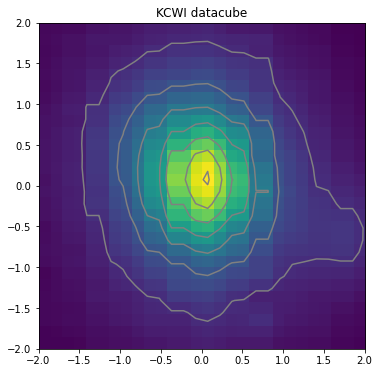

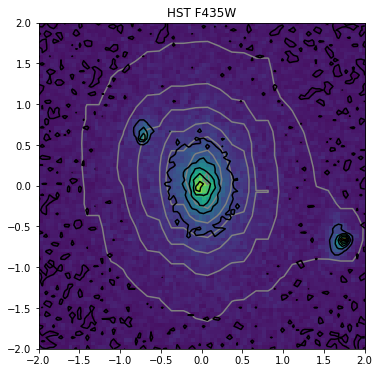

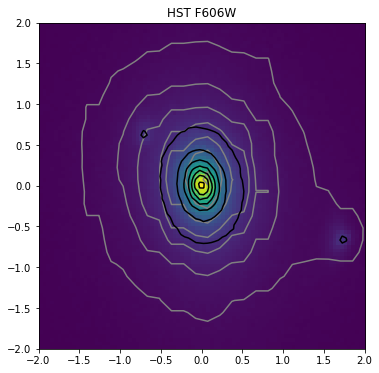

In [9]:
# import image, center, and crop

# effective radius in V band
# take photometry out to 4-5 r_eff
r_eff_V = 2.68
# take it out to 12 for actual mge
r_phot = 12

file = file_dir + "/KCWI_J0037_icubes_mosaic_0.1457_2Dintegrated.fits"
hdu = fits.open(file)
kcwi_img = hdu[0].data
header = hdu[0].header

kcwi_scale = 0.147  # arcsec/pixel r_eff_V

# crop the image to ~ 2 arcsec radius
central_pix = np.unravel_index(np.argmax(kcwi_img, axis=None), kcwi_img.shape)
central_pix_x = central_pix[1]
central_pix_y = central_pix[0]
half_width = int(np.around(2 / kcwi_scale))
kcwi_img = kcwi_img[central_pix_y - half_width:central_pix_y + half_width, central_pix_x - half_width:central_pix_x + half_width]

plt.clf()
plt.imshow(kcwi_img,origin='lower', extent=[-2,2,-2,2])#, extent=[0,50,0,50])
plt.contour(kcwi_img, colors='grey', extent=[-2,2,-2,2])
plt.title('KCWI datacube')
plt.pause(1)

# import image, center, and crop

file = f'/data/end_product/SLACS{obj_name}/cutouts{obj_name}_F435W.fits'
hdu = fits.open(file)
hstF435_img = hdu[0].data
header = hdu[0].header

hst_scale = 0.0455

# crop the image to 2 arcsec
central_pix_x = int(np.floor(hstF435_img.shape[0]/2))
central_pix_y = int(np.floor(hstF435_img.shape[1]/2))
half_width = int(np.around(2 / hst_scale))
hstF435_img = hstF435_img[central_pix_y - half_width:central_pix_y + half_width, central_pix_x - half_width:central_pix_x + half_width]

plt.clf()
plt.imshow(hstF435_img, origin='lower', extent=[-2,2,-2,2])
plt.contour(kcwi_img, colors='grey', extent=[-2,2,-2,2])
plt.contour(hstF435_img, colors='k', extent=[-2,2,-2,2])
plt.title('HST F435W')
plt.pause(1)

# import image, center, and crop

file = '/data/end_product/SLACS/SDSSJ0037-0942/cutouts/SDSSJ0037-0942_F606W.fits'
hdu = fits.open(file)
hstF606_img = hdu[0].data
header = hdu[0].header

# crop the image to 2 arcsec
central_pix_x = int(np.floor(hstF606_img.shape[0]/2))
central_pix_y = int(np.floor(hstF606_img.shape[1]/2))
half_width = int(np.around(2 / hst_scale))
hstF606_img = hstF606_img[central_pix_y - half_width:central_pix_y + half_width, central_pix_x - half_width:central_pix_x + half_width]

plt.clf()
plt.imshow(hstF606_img,origin='lower', extent=[-2,2,-2,2])#, extent=[0,50,0,50])
plt.contour(kcwi_img, colors='grey', extent=[-2,2,-2,2])
plt.contour(hstF606_img, colors='k', extent=[-2,2,-2,2])
plt.title('HST F606W')
plt.pause(1)

In [10]:
# Ooooooh look at that :)

# 4/19/22 - got some weird stuff going on... I'm going to go back to the HST image

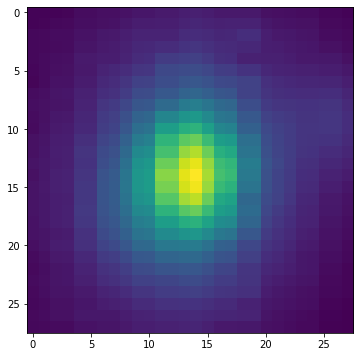

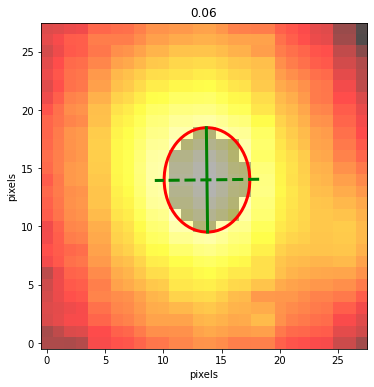

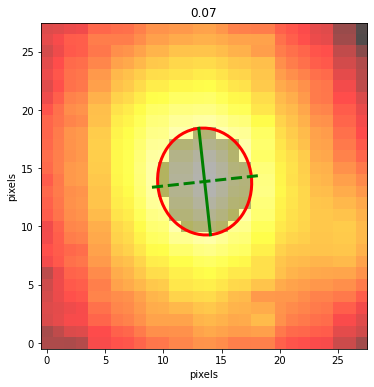

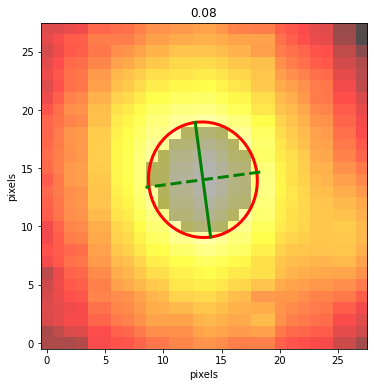

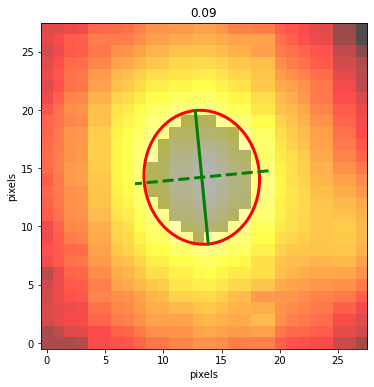

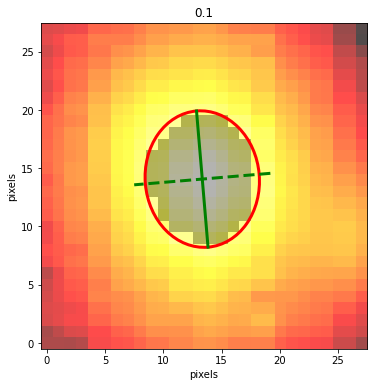

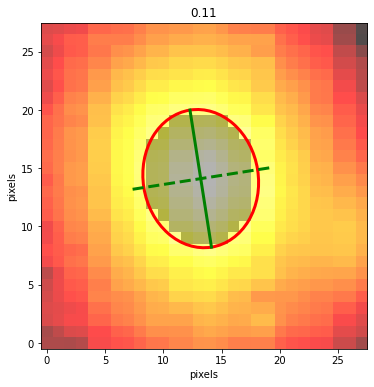

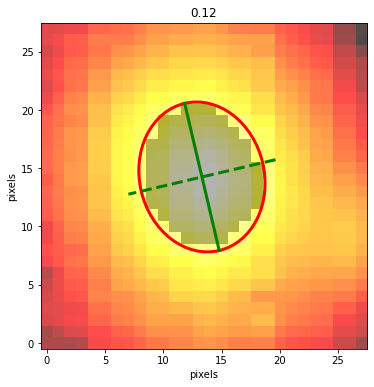

In [12]:
# sky, psf, scale, etc.
scale = kcwi_scale

img = kcwi_img

plt.clf()
plt.imshow(img)
plt.pause(1)
'''
I don't have a good selection for this? I'm guessing it's really like the noise level?
'''
minlevel = 0  # counts/pixel
# exposure time
exp_time = 1.5 * 3600 # seconds # keck
# Keck is typically 0.7-0.8
seeing_fwhm = 0.7 #0.1 # arcsec
sigmapsf = seeing_fwhm / scale / 2.355 # pixels, 2.355 is fwhm/sigma
#print(sigma_psf)

############################################################################################################################

# Here we use FIND_GALAXY directly inside the procedure. Usually you may want
# to experiment with different values of the FRACTION keyword, before adopting
# given values of Eps, Ang, Xc, Yc.

# take different values of pixel fractions
lower, upper, steps = (0.06, 0.12, 7)
fractions = np.linspace(lower, upper, steps)
    
eps_list = []
theta_list = []
#cen_y_list = [] # don't need these, already centered it
#cen_x_list = []

for frac in fractions:
    #print(f'Calculating fraction {frac}')
    frac = np.around(frac, 2)
    mid = np.around((upper+lower)/2, 2)
    plt.clf()
    #plt.clf()
    f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
    eps = f.eps
    theta = f.theta
    #cen_y = f.ypeak
    #cen_x = f.xpeak
    # assign to lists
    eps_list.append(eps)
    theta_list.append(theta)
    #cen_y_list.append(cen_y)
    #cen_x_list.append(cen_x)
    plt.title(f'{frac}')
    plt.pause(1)


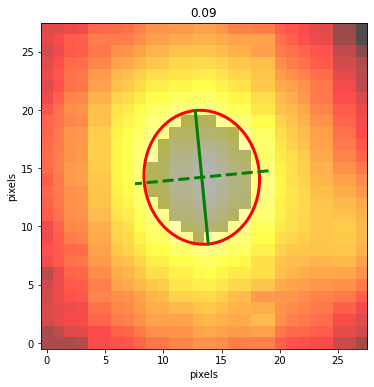

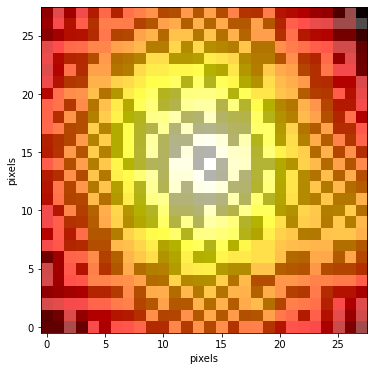

In [6]:
# fraction of 0.09 looks good
frac = 0.09

plt.clf()
#plt.clf()
f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
eps = f.eps
theta = f.theta
#cen_y = f.ypeak
#cen_x = f.xpeak
# assign to lists
#cen_y_list.append(cen_y)
#cen_x_list.append(cen_x)
plt.title(f'{frac}')
plt.pause(1)

#cen_y_med = np.median(cen_y_list)
#cen_x_med = np.median(cen_x_list)

# Perform galaxy photometry
plt.clf()
s = sectors_photometry(img, eps, theta, f.xpeak, f.ypeak,
                       minlevel=minlevel, plot=1)
#plt.contour(img, colors='k')
plt.pause(1)  # Allow plot to appear on the screen

Iteration:1  chi2: 2.335  Nonzero: 5/12
Iteration:11  chi2: 2.215  Nonzero: 4/12
Nonzero Gaussians: 4/12
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration:1  chi2: 2.215  Nonzero: 4/4
Iteration:11  chi2: 2.214  Nonzero: 4/4
Nonzero Gaussians: 4/4
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 0.32 seconds
  Total Iterations:  16
 Nonzero Gaussians:  4
  Unused Gaussians:  8
 Sectors used in the fit:  19
 Total number of points fitted:  252
 Chi2: 2.214 
 STDEV: 0.09331 
 MEANABSDEV: 0.06526 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  6.532978e+02      1.51653     0.810917
  3.804213e+03      3.29106     0.754433
  1.072673e+04      7.82148     0.867401
  3.122919e+03      9.55249     0.808060
++++++++++++++++++++++++++++++++++++++++++++


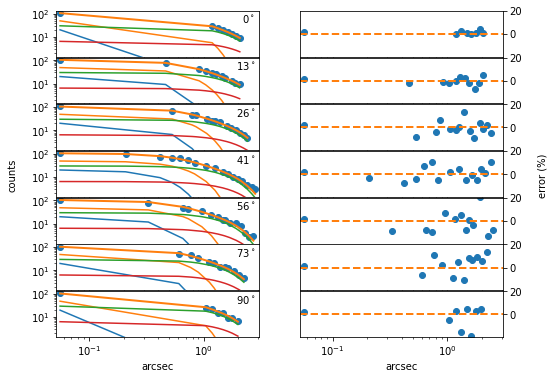

In [12]:

############################################################################################################################

# Do the actual MGE fit
# *********************** IMPORTANT ***********************************
# For the final publication-quality MGE fit one should include the line
# "from mge_fit_sectors_regularized import mge_fit_sectors_regularized"
# at the top of this file, rename mge_fit_sectors() into
# mge_fit_sectors_regularized() and re-run the procedure.
# See the documentation of mge_fit_sectors_regularized for details.
# *********************************************************************

# select number of gaussians to fit
ngauss = 12

# fit and plot
plt.clf()
m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                    ngauss=ngauss, sigmapsf=sigmapsf, #normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.pause(1)  # Allow plot to appear on the screen

# take the outputs
total_counts = m.sol[0]
sigma_pix = m.sol[1]
q = m.sol[2]
absdev = m.absdev

# calculate peak surface brightness of each gaussian
peak_surf_br = total_counts/(2*np.pi*q*sigma_pix**2)
# convert to johnson i band
# Here 20.840 is the photometric zeropint, 0.1 is a correction for infinite aperture to be applied 
# for surface brightness measurements, and AI is the extinction in the I-band
# dust extinction ~ 0.05 from https://irsa.ipac.caltech.edu/workspace/TMP_lFD64I_6198/DUST/SDSSJ0037-0942.v0002/extinction.html
AI = 0.05
iband_surf_br = 20.840 + 0.1 + 5 * np.log10(scale) + 2.5 * np.log10(exp_time) - 2.5 * np.log10(peak_surf_br) - AI
# convert to surface density (L_sol_I pc−2)
M_sol_I = 4.08
surf_density = (64800/np.pi)**2 * 10**( 0.4 * (M_sol_I - iband_surf_br))
# convert sigma from pixels to arcsec
sigma = sigma_pix * scale



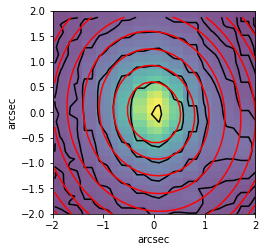

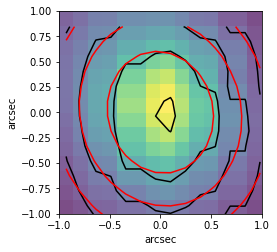

In [13]:
# Extract the central part of the image to plot at high resolution.
# The MGE is centered to fractional pixel accuracy to ease visual comparson.

n = int(np.around(2/scale))
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
plt.subplot(122)
mge_print_contours(img, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img, 
           origin='lower',
           extent = [-2, 2, -2, 2],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen


n = int(np.around(1/scale))
img_cen = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
xc_cen, yc_cen = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
plt.subplot(122)
mge_print_contours(img_cen, theta, xc_cen, yc_cen, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(img_cen, 
           origin='lower',
           extent = [-1, 1, -1, 1],
          alpha=0.7)
plt.pause(1)  # Allow plot to appear on the screen
    


___________________

# Try out JAM model step with the model that has psf 0.75



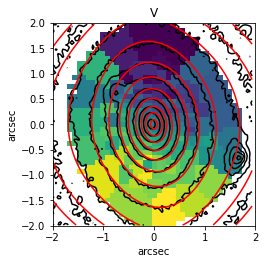

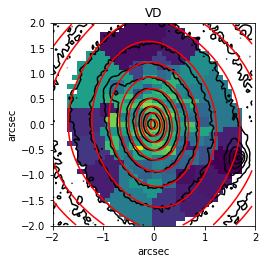

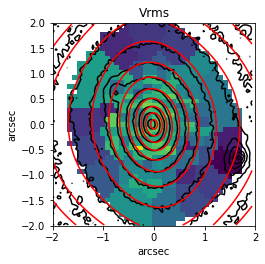

In [10]:
# read in kinematics files

V = np.genfromtxt(file_dir + obj_name + '_V_2d.txt', delimiter=',')
# find barycenter velocity (intrinsic velocity)
center_axis_index = int(np.floor(V.shape[0]/2))
Vbary = V[center_axis_index, center_axis_index]
V = V - Vbary

dV = np.genfromtxt(file_dir + obj_name + '_dV_2d.txt', delimiter=',')
VD = np.genfromtxt(file_dir + obj_name + '_VD_2d.txt', delimiter=',')
dVD = np.genfromtxt(file_dir + obj_name + '_dVD_2d.txt', delimiter=',')
Vrms = np.sqrt(V**2 + VD**2)
dVrms = np.sqrt((dV*V)**2 + (dVD*VD)**2)/Vrms

# show each with surface brightness contours

# V
plt.clf()
plt.subplot(122)
mge_print_contours(img, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(V, 
           extent = [-2, 2, -2, 2],
           origin='lower',
          alpha=1)
plt.title('V')
plt.pause(1)  # Allow plot to appear on the screen

# VD
plt.clf()
plt.subplot(122)
mge_print_contours(img, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(VD, 
           extent = [-2, 2, -2, 2],
           origin='lower',
          alpha=1)
plt.title('VD')
plt.pause(1)  # Allow plot to appear on the screen

# Vrms
plt.clf()
plt.subplot(122)
mge_print_contours(img, theta, xc, yc, m.sol,
                   sigmapsf=sigmapsf, #normpsf=normpsf, 
                   scale=scale)
plt.imshow(Vrms, 
           extent = [-2, 2, -2, 2],
           origin='lower',
          alpha=1)
plt.title('Vrms')
plt.pause(1)  # Allow plot to appear on the screen



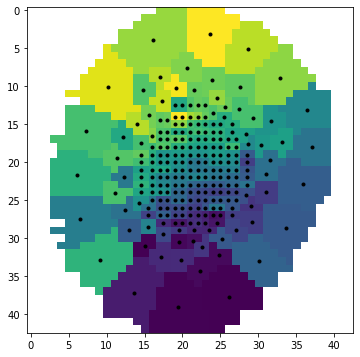

In [11]:
# bring in the velocity measurements and voronoi binning info
# use pandas for merging

import pandas as pd

vel_meas = np.genfromtxt(file_dir + '/VD.txt') # Vel, sigma, dv, dsigma
bins = np.arange(len(vel_meas))
V_bin = vel_meas[:,0]
V_bin = V_bin - Vbary
VD_bin = vel_meas[:,1]
dV_bin = vel_meas[:,2]
dVD_bin = vel_meas[:,3]
Vrms_bin = np.sqrt(V_bin**2 + VD_bin**2)
dVrms_bin = np.sqrt((dV_bin*V_bin)**2 + (dVD_bin*VD_bin)**2)/Vrms_bin

# bring in vor_bins x, y, bin
vor_bins = np.genfromtxt(file_dir + '/voronoi_2d_binning_KCWI_J0037_icubes_mosaic_0.1457_output.txt')
vor_bins_df = pd.DataFrame(vor_bins, columns=['x','y','bins'])

# loop through all bins and attach central bins
x_cen_bins = []
y_cen_bins = []

for bins in bins:
    
    # take all x and y in this bin
    xs = vor_bins_df[vor_bins_df.bins==bins]['x']
    ys = vor_bins_df[vor_bins_df.bins==bins]['y']
  
    # take mean of these coords
    x_mean = np.mean(xs)
    y_mean = np.mean(ys)
    
    x_cen_bins.append(x_mean)
    y_cen_bins.append(y_mean)
    
x_cen_bins = np.array(x_cen_bins)
y_cen_bins = np.array(y_cen_bins)

plt.imshow(V)
plt.scatter(x_cen_bins, y_cen_bins, color='k', marker='.')

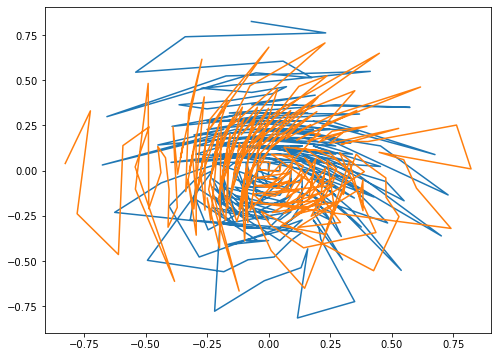

In [12]:
'''
x and y bins (pixels)
'''
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from plotbin.plot_velfield import plot_velfield

xbin_00 = x_cen_bins - center_axis_index
ybin_00 = y_cen_bins - center_axis_index

xbin_arcsec = xbin_00 * scale
ybin_arcsec = ybin_00 * scale

# set PA from mean photometry fitting
PA = theta

xbin = np.zeros(len(xbin_arcsec))
ybin = np.zeros(len(ybin_arcsec))
    
# rotate the coordinates and append to array
for i in range(len(xbin_arcsec)):
    xbin[i], ybin[i] = rotate_points(xbin_arcsec[i], ybin_arcsec[i], PA) 

plt.plot(xbin_arcsec, ybin_arcsec)
plt.plot(xbin, ybin)

####################################################
Inclination of 65 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 3.09
inc=65.0; beta[0]=0.50; kappa=1.00; M/L=604.; BH=6.0e+10; chi2/DOF=2.97
Total mass MGE (MSun): 2.024e+11


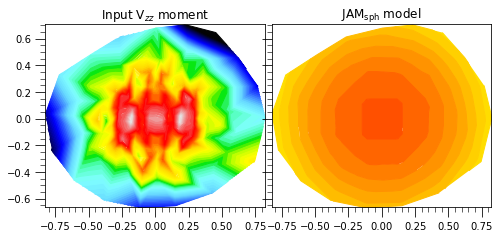

KeyboardInterrupt: 

In [17]:
"""
    Copyright (C) 2019-2021, Michele Cappellari

    E-mail: michele.cappellari_at_physics.ox.ac.uk

    Updated versions of the software are available from my web page
    http://purl.org/cappellari/software

CHANGELOG
---------

V1.1.0: MC, Oxford, 16 July 2020
    - Compute both Vrms and LOS velocity.
V1.0.1: MC, Oxford, 21 April 2020
    - Made a separate file
V1.0.0: Michele Cappellari, Oxford, 08 November 2019
    - Written and tested

"""
import numpy as np
import matplotlib.pyplot as plt

from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from plotbin.plot_velfield import plot_velfield

##############################################################################

#np.random.seed(123)
#xbin, ybin = np.random.uniform(low=[-55, -40], high=[55, 40], size=[1000, 2]).T

'''
What do I do for inclination?
'''
inclinations = np.arange(65,95,5)          # Assumed galaxy inclination

#r = np.sqrt(xbin**2 + (ybin/np.cos(np.radians(inc)))**2) # Radius in the plane of the disk
#a = 40                                                   # Scale length in arcsec
#vr = 2000*np.sqrt(r)/(r + a)                             # Assumed velocity profile (v_c of Hernquist 1990)
#vel = vr * np.sin(np.radians(inc))*xbin/r                # Projected velocity field
#sig = 8700/(r + a)                                       # Assumed velocity dispersion profile
#rms = np.sqrt(vel**2 + sig**2)                           # Vrms field in km/s

# Until here I computed some fake input kinematics to fit with JAM.
# Ina real application, instead of the above lines one will read the
# measured stellar kinematics, e.g. from integral-field spectroscopy



        
'''
surface density
'''
# take the surface density, etc from mge
surf = surf_density # surf_dens_list[2] <- this was with psf 0.75
sigma = sigma #sigma_list[2]
qObs = q #q_list[2]

from astropy.cosmology import Planck18 as cosmo  # Planck 2018
# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
mbh = 1e8 # Black hole mass in solar masses

# try different beta # TBD
#beta_list = [0.1,0.2,0.3,0.4,0.5]
beta = np.full_like(surf, 0.2)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C

surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = np.atleast_1d(sigmapsf)
sigmaX2 = sigma_lum**2 + sigmapsf[:, None]**2
sigmaY2 = (sigma_lum*qobs_lum)**2 + sigmapsf[:, None]**2
#normpsf = [0.7, 0.3]
pixsize = scale #0.8
goodbins = None

'''
run JAM
'''
# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

reduced_chi_squared = np.zeros((len(inclinations)))
i=0
for inc in inclinations:
    print('####################################################')
    print(f'Inclination of {inc} degrees')
    #for moment, data, errors in zip(['zz', 'z'], [Vrms, V], [dVrms, dV]):
    #    print()
    #    print(f'Moment {moment}')
    moment = 'zz'
    data = Vrms_bin
    errors = dVrms_bin
    
    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=None, nodots=True)
    plt.pause(3)
    plt.figure(2)
    #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared[i] = m.chi2
    i = i+1

# plot the inclinations
fig, axs = plt.subplots()
axs.plot(inclinations, reduced_chi_squared)
axs.set_ylabel(r'Reduced $\chi^2$')
axs.set_xlabel('Inclination')

####################################################
Inclination of 40 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.59
inc=40.0; beta[0]=0.50; kappa=1.00; M/L=0.623; BH=6.2e+07; chi2/DOF=4.55
Total mass MGE (MSun): 1.996e+12


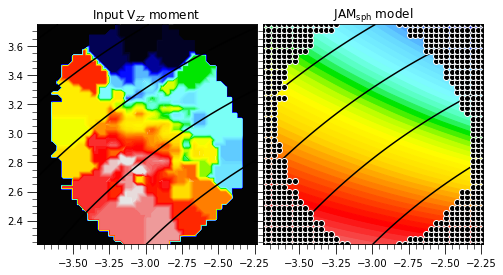

####################################################
Inclination of 50 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.71
inc=50.0; beta[0]=0.50; kappa=1.00; M/L=1.21; BH=1.2e+08; chi2/DOF=5.44
Total mass MGE (MSun): 2.416e+12


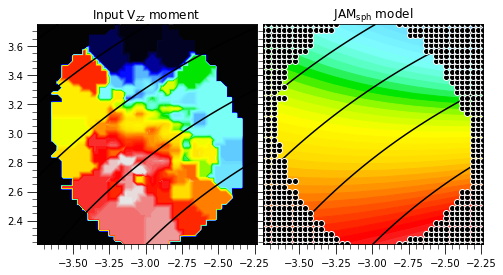

####################################################
Inclination of 60 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.46
inc=60.0; beta[0]=0.50; kappa=1.00; M/L=1.06; BH=1.1e+08; chi2/DOF=5.69
Total mass MGE (MSun): 2.557e+12


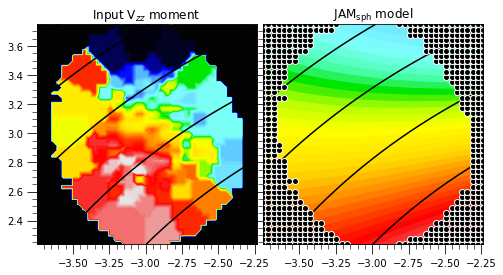

####################################################
Inclination of 70 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.42
inc=70.0; beta[0]=0.50; kappa=1.00; M/L=1.03; BH=1.0e+08; chi2/DOF=5.80
Total mass MGE (MSun): 2.623e+12


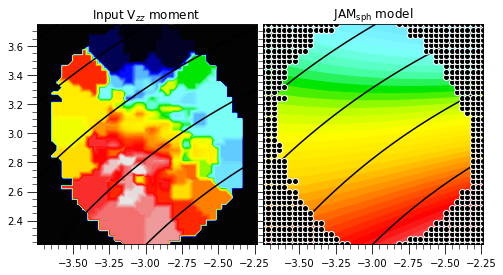

####################################################
Inclination of 80 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.46
inc=80.0; beta[0]=0.50; kappa=1.00; M/L=1.01; BH=1.0e+08; chi2/DOF=5.85
Total mass MGE (MSun): 2.655e+12


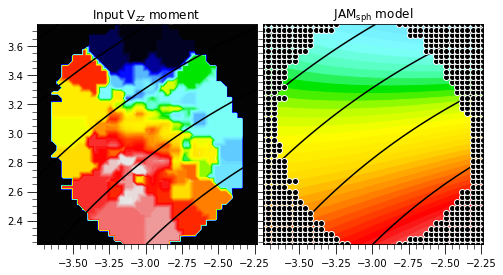

####################################################
Inclination of 90 degrees
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.51
inc=90.0; beta[0]=0.50; kappa=1.00; M/L=1.00; BH=1.0e+08; chi2/DOF=5.86
Total mass MGE (MSun): 2.664e+12


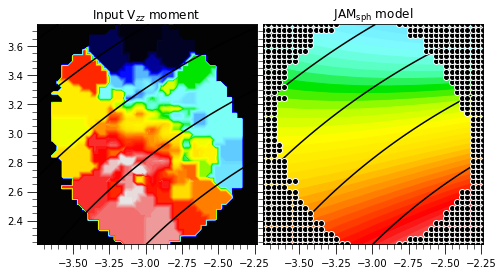

Text(0.5, 0, 'Inclination')

<Figure size 576x432 with 0 Axes>

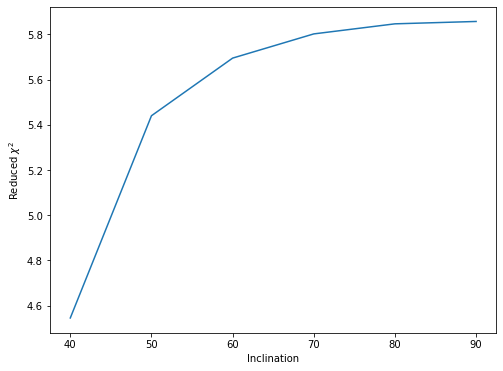

In [105]:
# try for a different value of beta
"""
    Copyright (C) 2019-2021, Michele Cappellari

    E-mail: michele.cappellari_at_physics.ox.ac.uk

    Updated versions of the software are available from my web page
    http://purl.org/cappellari/software

CHANGELOG
---------

V1.1.0: MC, Oxford, 16 July 2020
    - Compute both Vrms and LOS velocity.
V1.0.1: MC, Oxford, 21 April 2020
    - Made a separate file
V1.0.0: Michele Cappellari, Oxford, 08 November 2019
    - Written and tested

"""
import numpy as np
import matplotlib.pyplot as plt

from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from plotbin.plot_velfield import plot_velfield

##############################################################################

#np.random.seed(123)
#xbin, ybin = np.random.uniform(low=[-55, -40], high=[55, 40], size=[1000, 2]).T

'''
What do I do for inclination?
'''
inclinations = np.arange(40, 100, 10)          # Assumed galaxy inclination

#r = np.sqrt(xbin**2 + (ybin/np.cos(np.radians(inc)))**2) # Radius in the plane of the disk
#a = 40                                                   # Scale length in arcsec
#vr = 2000*np.sqrt(r)/(r + a)                             # Assumed velocity profile (v_c of Hernquist 1990)
#vel = vr * np.sin(np.radians(inc))*xbin/r                # Projected velocity field
#sig = 8700/(r + a)                                       # Assumed velocity dispersion profile
#rms = np.sqrt(vel**2 + sig**2)                           # Vrms field in km/s

# Until here I computed some fake input kinematics to fit with JAM.
# Ina real application, instead of the above lines one will read the
# measured stellar kinematics, e.g. from integral-field spectroscopy

'''
Open kinematics maps
'''
V = np.genfromtxt(file_dir + obj_name + '_V_2d.txt', delimiter=',')
dV = np.genfromtxt(file_dir + obj_name + '_dV_2d.txt', delimiter=',')
VD = np.genfromtxt(file_dir + obj_name + '_VD_2d.txt', delimiter=',')
dVD = np.genfromtxt(file_dir + obj_name + '_dVD_2d.txt', delimiter=',')
# compute rms velocity
Vrms = np.sqrt(V**2 + VD**2)
dVrms = np.sqrt((dV*V)**2 + (dVD*VD)**2)/Vrms

'''
x and y bins (pixels)
'''
# write the grid of xbins and ybins with (0,0) at the center and the x-axis corresponding to major axis
# set x and y bins so that center is (0, 0)
size = V.shape[0]

xbin_arcsec = np.linspace(-np.floor(size/2), np.floor(size/2), size) * scale
ybin_arcsec = np.linspace(-np.floor(size/2), np.floor(size/2), size) * scale

# set PA from mean photometry fitting
PA = theta

# set new arrays with the rotated coordinates
xbin_rot = np.zeros(size)
ybin_rot = np.zeros(size)
    
# rotate the coordinates and append to array
for i in range(len(xbin_arcsec)):
    for j in range(len(ybin_arcsec)):
        x_new, y_new = rotate_points(xbin_arcsec[i], ybin_arcsec[j], PA)
        xbin_rot[i] = x_new
        ybin_rot[j] = y_new
        
xbin, ybin = np.meshgrid(xbin_rot, ybin_rot)

'''
flatten data and bins
'''
V = V.flatten()
dV = dV.flatten()
VD = VD.flatten()
dVD = dVD.flatten()
Vrms = Vrms.flatten()
dVrms = dVrms.flatten()
xbin = xbin.flatten()
ybin = ybin.flatten()
        
'''
surface density
'''
# take the surface density, etc from mge
surf = surf_density # surf_dens_list[2] <- this was with psf 0.75
sigma = sigma #sigma_list[2]
qObs = q #q_list[2]

from astropy.cosmology import Planck18 as cosmo  # Planck 2018
# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
mbh = 1e8 # Black hole mass in solar masses

# try different beta # TBD
#beta_list = [0.1,0.2,0.3,0.4,0.5]
beta = np.full_like(surf, 0.5)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C

surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = 0.75
sigmapsf = np.atleast_1d(sigmapsf)
sigmaX2 = sigma_lum**2 + sigmapsf[:, None]**2
sigmaY2 = (sigma_lum*qobs_lum)**2 + sigmapsf[:, None]**2
#normpsf = [0.7, 0.3]
pixsize = scale #0.8
goodbins = np.isfinite(Vrms) # take finite data

'''
run JAM
'''
# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

reduced_chi_squared = np.zeros((len(inclinations)))
i=0
for inc in inclinations:
    print('####################################################')
    print(f'Inclination of {inc} degrees')
    #for moment, data, errors in zip(['zz', 'z'], [Vrms, V], [dVrms, dV]):
    #    print()
    #    print(f'Moment {moment}')
    moment = 'zz'
    data = Vrms
    errors = dVrms
    
    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=None, nodots=True)
    plt.pause(3)
    plt.figure(2)
    surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared[i] = m.chi2
    i = i+1

# plot the inclinations
fig, axs = plt.subplots()
axs.plot(inclinations, reduced_chi_squared)
axs.set_ylabel(r'Reduced $\chi^2$')
axs.set_xlabel('Inclination')

# take it at 40 degrees and vary beta

####################################################
Beta=0.05
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.69
inc=40.0; beta[0]=0.050; kappa=1.00; M/L=1.01; BH=1.0e+08; chi2/DOF=4.36
Total mass MGE (MSun): 1.648e+12


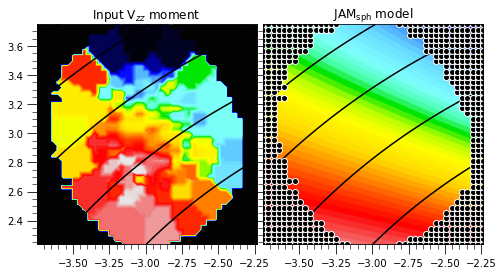

####################################################
Beta=0.1
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.74
inc=40.0; beta[0]=0.10; kappa=1.00; M/L=1.01; BH=1.0e+08; chi2/DOF=4.37
Total mass MGE (MSun): 1.669e+12


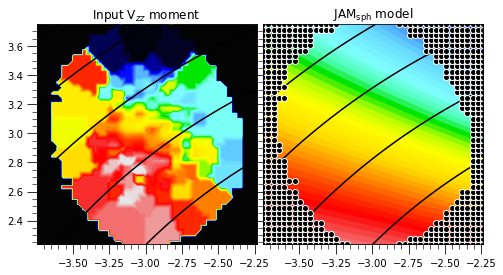

####################################################
Beta=0.15000000000000002
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.75
inc=40.0; beta[0]=0.15; kappa=1.00; M/L=1.01; BH=1.0e+08; chi2/DOF=4.38
Total mass MGE (MSun): 1.693e+12


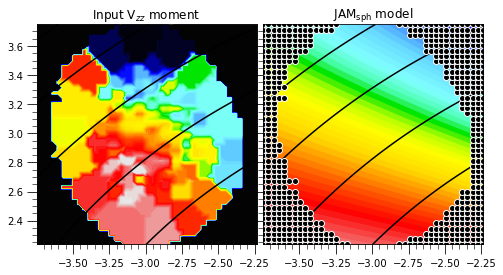

####################################################
Beta=0.2
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.86
inc=40.0; beta[0]=0.20; kappa=1.00; M/L=1.02; BH=1.0e+08; chi2/DOF=4.39
Total mass MGE (MSun): 1.720e+12


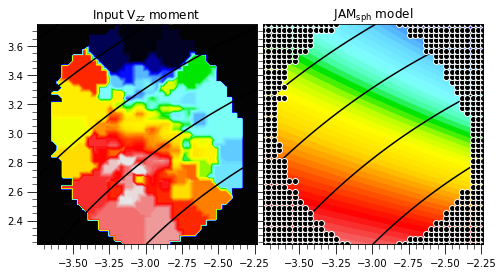

####################################################
Beta=0.25
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.72
inc=40.0; beta[0]=0.25; kappa=1.00; M/L=1.02; BH=1.0e+08; chi2/DOF=4.41
Total mass MGE (MSun): 1.751e+12


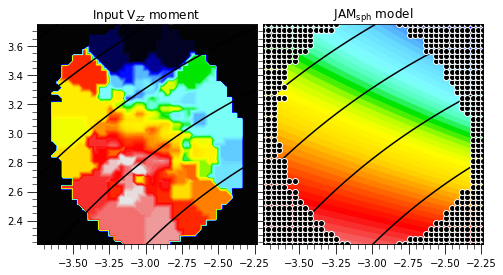

####################################################
Beta=0.3
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.68
inc=40.0; beta[0]=0.30; kappa=1.00; M/L=1.02; BH=1.0e+08; chi2/DOF=4.42
Total mass MGE (MSun): 1.786e+12


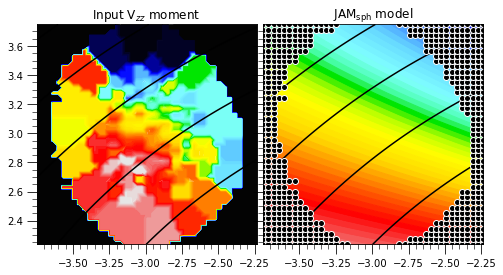

####################################################
Beta=0.35000000000000003
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.70
inc=40.0; beta[0]=0.35; kappa=1.00; M/L=1.02; BH=1.0e+08; chi2/DOF=4.45
Total mass MGE (MSun): 1.826e+12


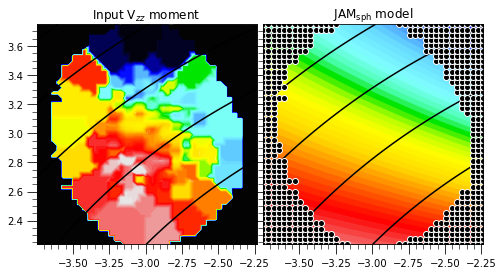

####################################################
Beta=0.4
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.76
inc=40.0; beta[0]=0.40; kappa=1.00; M/L=1.03; BH=1.0e+08; chi2/DOF=4.47
Total mass MGE (MSun): 1.874e+12


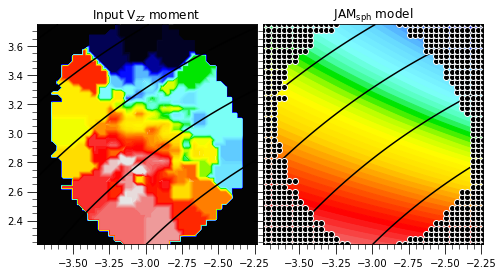

####################################################
Beta=0.45
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.65
inc=40.0; beta[0]=0.45; kappa=1.00; M/L=1.03; BH=1.0e+08; chi2/DOF=4.50
Total mass MGE (MSun): 1.929e+12


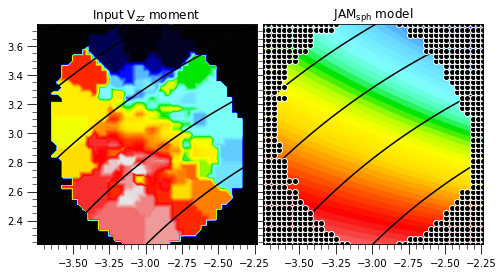

Text(0.5, 0, '$\\beta$')

<Figure size 576x432 with 0 Axes>

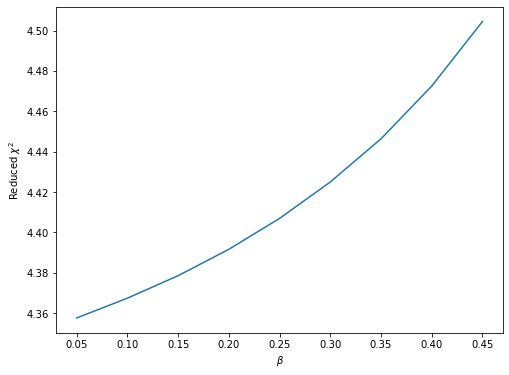

In [101]:
# try for a different value of beta
"""
    Copyright (C) 2019-2021, Michele Cappellari

    E-mail: michele.cappellari_at_physics.ox.ac.uk

    Updated versions of the software are available from my web page
    http://purl.org/cappellari/software

CHANGELOG
---------

V1.1.0: MC, Oxford, 16 July 2020
    - Compute both Vrms and LOS velocity.
V1.0.1: MC, Oxford, 21 April 2020
    - Made a separate file
V1.0.0: Michele Cappellari, Oxford, 08 November 2019
    - Written and tested

"""
import numpy as np
import matplotlib.pyplot as plt

from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from plotbin.plot_velfield import plot_velfield

##############################################################################

#np.random.seed(123)
#xbin, ybin = np.random.uniform(low=[-55, -40], high=[55, 40], size=[1000, 2]).T

'''
What do I do for inclination?
'''
#inclinations = [40.,45.,50.,55.,60.,65.,70.,75.,80.,85.,90.]          # Assumed galaxy inclination
inc = 40.

#r = np.sqrt(xbin**2 + (ybin/np.cos(np.radians(inc)))**2) # Radius in the plane of the disk
#a = 40                                                   # Scale length in arcsec
#vr = 2000*np.sqrt(r)/(r + a)                             # Assumed velocity profile (v_c of Hernquist 1990)
#vel = vr * np.sin(np.radians(inc))*xbin/r                # Projected velocity field
#sig = 8700/(r + a)                                       # Assumed velocity dispersion profile
#rms = np.sqrt(vel**2 + sig**2)                           # Vrms field in km/s

# Until here I computed some fake input kinematics to fit with JAM.
# Ina real application, instead of the above lines one will read the
# measured stellar kinematics, e.g. from integral-field spectroscopy

'''
Open kinematics maps
'''
V = np.genfromtxt(file_dir + obj_name + '_V_2d.txt', delimiter=',')
dV = np.genfromtxt(file_dir + obj_name + '_dV_2d.txt', delimiter=',')
VD = np.genfromtxt(file_dir + obj_name + '_VD_2d.txt', delimiter=',')
dVD = np.genfromtxt(file_dir + obj_name + '_dVD_2d.txt', delimiter=',')
# compute rms velocity
Vrms = np.sqrt(V**2 + VD**2)
dVrms = np.sqrt((dV*V)**2 + (dVD*VD)**2)/Vrms

'''
x and y bins (pixels)
'''
# write the grid of xbins and ybins with (0,0) at the center and the x-axis corresponding to major axis
# set x and y bins so that center is (0, 0)
size = V.shape[0]

xbin_arcsec = np.linspace(-np.floor(size/2), np.floor(size/2), size) * scale
ybin_arcsec = np.linspace(-np.floor(size/2), np.floor(size/2), size) * scale

# set PA from mean photometry fitting
PA = theta

# set new arrays with the rotated coordinates
xbin_rot = np.zeros(size)
ybin_rot = np.zeros(size)
    
# rotate the coordinates and append to array
for i in range(len(xbin_arcsec)):
    for j in range(len(ybin_arcsec)):
        x_new, y_new = rotate_points(xbin_arcsec[i], ybin_arcsec[j], PA)
        xbin_rot[i] = x_new
        ybin_rot[j] = y_new
        
xbin, ybin = np.meshgrid(xbin_rot, ybin_rot)

'''
flatten data and bins
'''
V = V.flatten()
dV = dV.flatten()
VD = VD.flatten()
dVD = dVD.flatten()
Vrms = Vrms.flatten()
dVrms = dVrms.flatten()
xbin = xbin.flatten()
ybin = ybin.flatten()
        
'''
surface density
'''
# take the surface density, etc from mge
surf = surf_density # surf_dens_list[2] <- this was with psf 0.75
sigma = sigma #sigma_list[2]
qObs = q #q_list[2]

from astropy.cosmology import Planck18 as cosmo  # Planck 2018
# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
mbh = 1e8 # Black hole mass in solar masses

# try different beta # TBD
betas = np.arange(0.05, 0.5, 0.05)

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C

surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs
sigmapsf = 0.75
sigmapsf = np.atleast_1d(sigmapsf)
sigmaX2 = sigma_lum**2 + sigmapsf[:, None]**2
sigmaY2 = (sigma_lum*qobs_lum)**2 + sigmapsf[:, None]**2
#normpsf = [0.7, 0.3]
pixsize = scale #0.8
goodbins = np.isfinite(Vrms) # take finite data

'''
run JAM
'''
# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

reduced_chi_squared = np.zeros((len(betas)))
i=0
for beta in betas:
    print('####################################################')
    print(f'Beta={beta}')
    beta = np.full_like(surf, beta)
    #for moment, data, errors in zip(['zz', 'z'], [Vrms, V], [dVrms, dV]):
    #    print()
    #    print(f'Moment {moment}')
    moment = 'zz'
    data = Vrms
    errors = dVrms
    
    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=None, nodots=True)
    plt.pause(3)
    plt.figure(2)
    surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared[i] = m.chi2
    i = i+1

# plot the inclinations
fig, axs = plt.subplots()
axs.plot(betas, reduced_chi_squared)
axs.set_ylabel(r'Reduced $\chi^2$')
axs.set_xlabel(r'$\beta$')

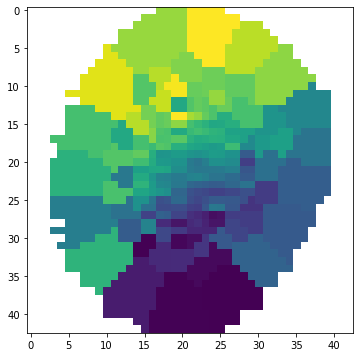

In [31]:
V = np.genfromtxt(file_dir + obj_name + '_V_2d.txt', delimiter=',')
plt.imshow(V)

In [47]:
#The image is flipped vertically!!!

'\nThe image is flipped vertically!!!! This was so weird to try to figure out.\n'

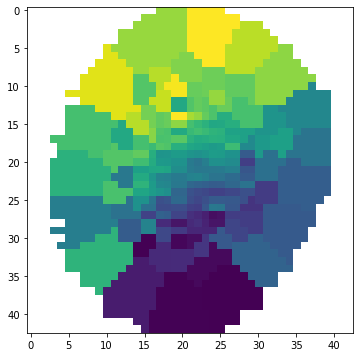

In [51]:
V = V.flatten()
V = V.reshape(43,43)
plt.imshow(V)

#Does it get flipped in JAM?